# Compute Interventions

by Jonas Peters, Niklas Pfister and Rune Christiansen, 18.06.2019

This notebook is intended to give you some insight on how to compute intervention distributions. Intervention distributions can be obtained from the observational distribution and the causal graph by so-called _covariate adjustment_, or by direct manipulations of the structural assignments in a structural causal model. 


In [1]:
library(igraph) #comment out this line if you cannot install igraph 
library(CondIndTests) 
library(dHSIC)
source("./utils.R")


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: nlme
This is mgcv 1.8-17. For overview type 'help("mgcv-package")'.


## Covariate adjustment

Consider a causal model over variables $\mathbf{X}$ and assume that we are interested in the distribution of $Y \in \mathbf{X}$ under the (atomic) intervention 
$$
do(X:= x)
$$
on some other variable $X \in \mathbf{X} \setminus \{Y\}$. This interventional distribution can be computed from the observational distribution and the causal graph by covariate adjustment, also called the G-formula. It says
(in case of discrete variables, the integral is replaced by a sum)
\begin{equation} \tag{1}
p^{do(X:=x)} (y) = \int_{\mathbf{z}} p(y|x, \mathbf{z}) p(\mathbf{z}) \, d\mathbf{z},
\end{equation}
where $\mathbf{Z}$ is a _valid adjustment set_ for $(X,Y)$. Usually, there are several valid adjustment sets. One set $\mathbf{Z}$ that always works, is the set of parents of $X$, i.e., $\mathbf{Z} = \mathbf{PA}_X$.




We will apply formula (1) to a (famous) kidney stone data set. Let us assume that the causal structure looks as follows.  
\begin{align}
    &\phantom{0}\\
    &\begin{array}{cc}
         &S                 & \\
        \phantom{abcdefgh}\swarrow &            & \searrow\phantom{abcdefgh}\\
                            &               & \\
         T                  & \longrightarrow & R\\
        \end{array}\\
      &\phantom{0}
\end{align}
where $T \in \{A,B\}$ is treatment, $S \in \{\text{small}, \text{large}\}$ is the size of the stone, and $R \in \{0,1\}$ is the recovery indicator. The data can be summarized in a 2x2 table, in which each entry corresponds to the observed recovery rate for a given combination of ($T$, $S$):

$$
\begin{array}{r|c|c|c}
& \text{Treatment A} & \text{Treatment B}\\\hline
\text{Small Stones } & \frac{81}{87} = {0.93} & \frac{234}{270} = 0.87 & \frac{357}{700} = 0.51 \\ \hline
\text{Large Stones } & \frac{192}{263} = {0.73} & \frac{55}{80} = 0.69 & \frac{343}{700} = 0.49 \\ \hline
& \frac{273}{350} = 0.78 & \frac{289}{350} = {0.83}
\end{array}
$$

### Exercise 1: 
Compute 
$$
P^{do(T:=A)} (R = 1)
$$
and
$$
P^{do(T:=B)} (R = 1).
$$
Which treatment is better?

### Solution 1: 

### End of Solution 1

For the remainder of this notebook we will have a look at an artificial example. It is based on the following data set. 

In [2]:
load(file = "./ComputeInterventionsData1.Rdata")

 The data are stored in ```data.loaded```, and you can access variables using ```data.loaded[,"X"]```, for example. They are generated from a linear SCM with zero-mean Gaussian noise variables and the following graph structure. 

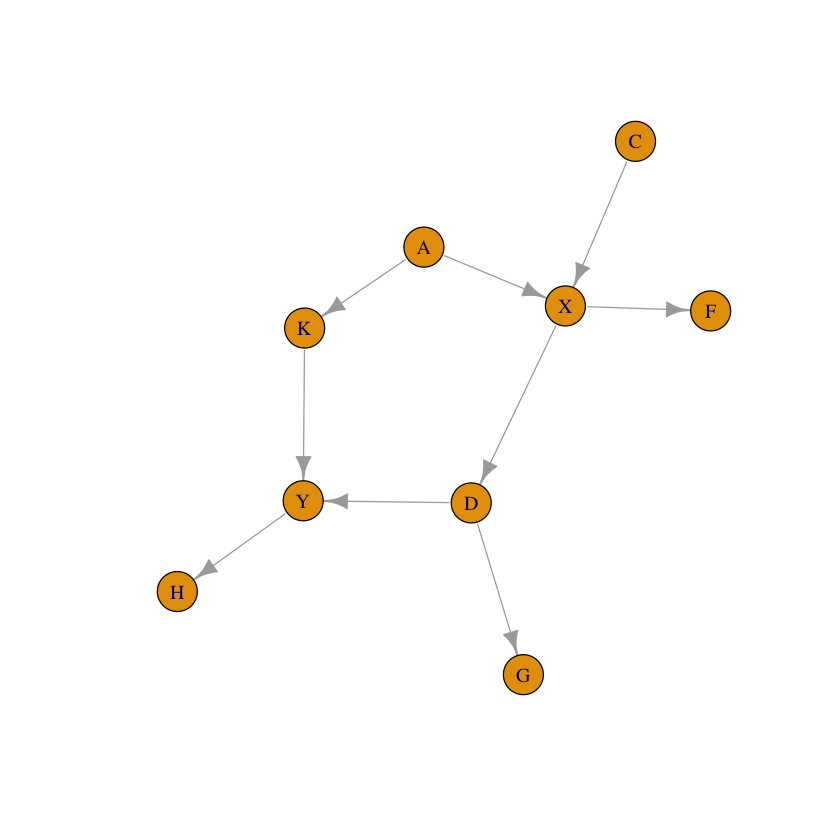

In [3]:
Adj <- rbind(c(0,0,0,1,0,0,0,0,0), c(0,0,1,1,0,0,0,0,0), c(0,0,0,0,0,0,0,1,0), c(0,0,0,0,1,1,0,0,0), 
           c(0,0,0,0,0,0,0,0,0), c(0,0,0,0,0,0,1,1,0), c(0,0,0,0,0,0,0,0,0), c(0,0,0,0,0,0,0,0,1), 
           c(0,0,0,0,0,0,0,0,0))
set.seed(1)
plotGraphfromAdj(Adj, labels = c("C", "A", "K", "X", "F", "D", "G", "Y", "H")) 
#comment out the above line if you cannot install igraph


Let us say, we are interested in the causal effect from $X$ to $Y$, i.e., in the intervention distribution $p^{do(X:=x)} (y)$. Let $\mathbf{Z}$ be a valid adjustment set for $(X,Y)$. 

In general, computing Equation (1) is a difficult problem, even if we are given full knowledge of the observational distribution, that is, the density $p$. (This is especially true in the case of continuous variables and high-dimensional $\mathbf{Z}$.) In this example, we are not even given $p$ but only a sample from $p$, and estimating conditional distributions is a hard statistical problem. Fortunately, the joint distribution $p$ is Gaussian and things become easier. Namely, we know that there exist $\alpha \in \mathbb{R}$ and $\beta \in \mathbb{R}^{\text{dim}(\mathbf{Z})}$ such that for all $x,z$,
$$
\mathbf{E} [Y\,| \,X=x, \mathbf{Z} = \mathbf{z}] = \alpha x + \beta^t \mathbf{z}.
$$
Exploiting that $\mathbb{E}[\mathbf{Z}] = 0$, Equation (1) then implies that for all $x \in \mathbb{R}$,
\begin{equation} \tag{2}
\mathbf{E}^{do(X:=x)} [Y] = \alpha x.
\end{equation}
(If you are interested, try to prove that statement.)

In practice, we can thus
obtain $\alpha$ as the regression coefficient, when linearly regressing $Y$ on $X$ and $\mathbf{Z}$.


### Exercise 2: 
1. Estimate
$
\mathbf{E}^{do(X:=3)} [Y] 
$
from ```data.loaded```.

2. 
We have regressed 
$Y$ on $X$ *and* $\mathbf{Z}$ --- thus the name ''adjusting for $\mathbf{Z}$''.
Do you see what goes wrong when we try to estimate the causal effect $\alpha$ 
by regressing $Y$ on $X$ without adjusting for $\mathbf{Z}$?

### Solution 2: 

### End of Solution 2 

## d-separation and conditional independence

Whether or not a set is a valid adjustment set can be answered using the notion of d-separation (the set should block the path $X \leftarrow A \rightarrow K \rightarrow Y$, for example). Since d-separation is an important concept, we would like to revise it here. 

In brief, given a DAG, the (disjoint) sets $Q$ and $R$ are d-separated by a set $S$, if all paths between $Q$ and $R$ are blocked by $S$. A path $i_1, i_2, \ldots, i_m$ is blocked by $S$, if there is a node $i_k$ on the path ($1 < k < m$) such that one of the following conditions hold:
* ${i_k} \in {S}$ and
\begin{align*}
&{i_{k-1}} \rightarrow {i_k} \rightarrow {i_{k+1}}\\
\text{or }\;&{i_{k-1}} \leftarrow {i_k} \leftarrow {i_{k+1}}\\
\text{or }\;&{i_{k-1}} \leftarrow {i_k} \rightarrow {i_{k+1}}
\end{align*}
* neither ${i_k}$ nor any of its descendants is in ${S}$ and
$$
{i_{k-1}} \rightarrow {i_k} \leftarrow {i_{k+1}}.
$$ 

A distribution $\mathbb{P}$ is said to be Markov wrt a graph $\mathcal{G}$, if all $d$-separations in $\mathcal{G}$ correspond to conditional independencies in $\mathbb{P}$. One can show that the distribution induced by an SCM is Markov with respect to the corresponding causal graph. We will try to verify this with a few examples. 

### Exercise 3: 
Write down two d-separation statements that hold in the above graph, and two that do not hold. Test the corresponding unconditional or conditional independence statements in <tt>data.loaded</tt> using the functions ```CondIndTest``` from package ```CondIndTests``` and ```dhsic.test``` from package ```dHSIC```, respectively. Do you find the correct (conditional) independences? Note that conditional independence testing is a difficult statistical problem, especially if the conditioning set is large.

### Solution 3: 

### End of Solution 3

## Computing interventions directly from an SCM

If we are given the full SCM (which will often not be the case), there is a different strategy for computing causal effects. We will use this approach to validate our estimate from Exercise 2. In fact, the data that we have provided above, were generated by the following SCM:
\begin{align*} 
C &:= N_C\\
A &:=  0.8 N_A\\
K &:=  A + 0.1 N_K\\
X &:=  C - 2 A + 0.2 N_X\\
F &:=  3 X + 0.8 N_F\\
D &:=  -2 X + 0.5 N_D\\
G &:=  D + 0.5 N_G\\
Y &:=  2 K - D + 0.2 N_Y\\
H &:=  0.5 Y + 0.1 N_H
\end{align*}
with all $N$'s being jointly independent and having a standard normal distribution.


In [5]:
set.seed(1); n <- 200
C <- rnorm(n)
A <- 0.8*rnorm(n)
K <- A + 0.1*rnorm(n)
X <- C - 2*A + 0.2*rnorm(n)
F <- 3*X + 0.8*rnorm(n)
D <- -2*X + 0.5*rnorm(n)
G <- D + 0.5*rnorm(n)
Y <- 2*K - D + 0.2*rnorm(n)
H <- 0.5*Y + 0.1*rnorm(n)
data.check <- cbind(C, A, K, X, F, D, G, Y, H)

Indeed, this yields the same data:

In [6]:
head(data.loaded)
head(data.check)

C,A,K,X,F,D,G,Y,H
-0.6264538,0.3275215,0.4349656,-1.349710,-4.918658,3.266903,2.488385,-2.087595,-1.0093783
0.1836433,1.3510986,1.5406641,-2.218069,-8.115073,4.992104,5.953686,-1.874992,-0.9362238
-0.8356286,1.2692707,1.2089710,-3.268509,-9.009300,6.101628,5.173213,-3.740196,-1.9574428
1.5952808,-0.2647262,-0.3038130,2.233172,6.690025,-4.360977,-5.414037,3.599892,1.8342258
0.3295078,-1.8281884,-1.8698106,3.958550,11.395947,-7.882402,-7.533578,4.027500,1.9960112
-0.8204684,1.9981293,1.9605635,-5.044074,-15.274579,9.256823,9.710545,-5.518667,-2.6671902


C,A,K,X,F,D,G,Y,H
-0.6264538,0.3275215,0.4349656,-1.349710,-4.918658,3.266903,2.488385,-2.087595,-1.0093783
0.1836433,1.3510986,1.5406641,-2.218069,-8.115073,4.992104,5.953686,-1.874992,-0.9362238
-0.8356286,1.2692707,1.2089710,-3.268509,-9.009300,6.101628,5.173213,-3.740196,-1.9574428
1.5952808,-0.2647262,-0.3038130,2.233172,6.690025,-4.360977,-5.414037,3.599892,1.8342258
0.3295078,-1.8281884,-1.8698106,3.958550,11.395947,-7.882402,-7.533578,4.027500,1.9960112
-0.8204684,1.9981293,1.9605635,-5.044074,-15.274579,9.256823,9.710545,-5.518667,-2.6671902


### Exercise 4: 
1. Generate data from the intervened SCM $do(X:=3)$ and compare your findings with the estimate of $\mathbf{E}^{do(X:=3)}[Y]$ computed above. 
2. Look at the graph shown above and at the coefficients of the SCM. Can you guess the correct value for $\mathbf{E}^{do(X:=3)}[Y]$? 


### Solution 4: 

### End of Solution 4 